In [1]:
from IPython.core.display import Image

import numpy as np
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like # remove once updated pandas-datareader issue is fixed
# https://github.com/pydata/pandas-datareader/issues/534
import pandas_datareader.data as web
%matplotlib inline

In [2]:
def get_symbols(symbols, data_source, begin_date=None, end_date=None):
    out = pd.DataFrame()
    for symbol in symbols:
        df = web.DataReader(symbol, data_source, begin_date, end_date, api_key='2gwP5WpwYPiHshKy1H9v')\
        [['AdjOpen','AdjHigh','AdjLow','AdjClose','AdjVolume']].reset_index()
        df.columns = ['date','open','high','low','close','volume'] #my convention: always lowercase
        df['symbol'] = symbol # add a new column which contains the symbol so we can keep multiple symbols in the same dataframe
        df = df.set_index(['date', 'symbol'])
        out = pd.concat([out, df], axis=0) #stacks on top of previously collected data
    return out.sort_index()
        
prices = get_symbols(['AAPL','CSCO'], data_source='quandl', begin_date='2012-01-01',end_date=None)

In [3]:
outcomes = pd.DataFrame(index=prices.index)
# next day's opening change
outcomes['close_1'] = prices.groupby(level='symbol').close.pct_change(-1) # next day's returns
outcomes['close_5'] = prices.groupby(level='symbol').close.pct_change(-5) # next week's returns
outcomes['close_10'] = prices.groupby(level='symbol').close.pct_change(-10) # next two weeks' returns
outcomes['close_20'] = prices.groupby(level='symbol').close.pct_change(-20) # next month's (approx) returns

print(outcomes.tail())

                    close_1  close_5  close_10  close_20
date       symbol                                       
2018-03-23 CSCO   -0.037222      NaN       NaN       NaN
2018-03-26 AAPL    0.026316      NaN       NaN       NaN
           CSCO    0.032334      NaN       NaN       NaN
2018-03-27 AAPL         NaN      NaN       NaN       NaN
           CSCO         NaN      NaN       NaN       NaN


In [4]:
num_obs = prices.close.count()
factor_1 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_2 = pd.Series(np.random.randn(num_obs),index=prices.index)
factor_3 = pd.Series(np.random.randn(num_obs),index=prices.index)
outcome = 1.*factor_1 + 2.*factor_2 + 3.*factor_3 + 5.*np.random.randn(num_obs)
outcome.name = 'outcome'
print(outcome.tail())

date        symbol
2018-03-23  CSCO     -1.557113
2018-03-26  AAPL     -2.961053
            CSCO      6.598796
2018-03-27  AAPL      2.237418
            CSCO      1.183162
Name: outcome, dtype: float64


In [5]:
features = pd.DataFrame(index=outcomes.index)
features['f11'] = 0.2*factor_1 + 0.8*np.random.randn(num_obs)
features['f12'] = 0.4*factor_1 + 0.6*np.random.randn(num_obs)
features['f13'] = 0.6*factor_1 + 0.4*np.random.randn(num_obs)

features['f21'] = 0.2*factor_2 + 0.8*np.random.randn(num_obs)
features['f22'] = 0.4*factor_2 + 0.8*np.random.randn(num_obs)
features['f23'] = 0.6*factor_2 + 0.4*np.random.randn(num_obs)

features['f31'] = 0.2*factor_3 + 0.8*np.random.randn(num_obs)
features['f32'] = 0.4*factor_3 + 0.6*np.random.randn(num_obs)
features['f33'] = 0.6*factor_3 + 0.4*np.random.randn(num_obs)

features['f41'] = 0.2*factor_1+0.2*factor_2 + 0.6*np.random.randn(num_obs)
features['f42'] = 0.2*factor_2+0.2*factor_3 + 0.6*np.random.randn(num_obs)
features['f43'] = 0.2*factor_3+0.2*factor_1 + 0.6*np.random.randn(num_obs)

features['f51'] = np.random.randn(num_obs)
features['f52'] = np.random.randn(num_obs)
features['f53'] = np.random.randn(num_obs)

print(features.tail())

                        f11       f12       f13       f21       f22       f23  \
date       symbol                                                               
2018-03-23 CSCO   -0.453862 -0.831259 -1.171829 -0.938000  1.670334 -0.490196   
2018-03-26 AAPL   -0.065344 -1.129890 -0.072332  1.388447 -0.264404 -0.640615   
           CSCO   -0.341276 -0.150351 -0.329578  0.500101  0.715117 -0.884725   
2018-03-27 AAPL   -0.594074 -0.051822  0.299686 -0.125793 -0.427768 -0.507621   
           CSCO    1.771646 -0.864246  0.393326 -0.656653  0.465714 -0.617299   

                        f31       f32       f33       f41       f42       f43  \
date       symbol                                                               
2018-03-23 CSCO   -0.401682  0.113182  0.870443  0.642330  0.549269 -0.194270   
2018-03-26 AAPL    0.180226 -0.095307 -0.713057  0.670369  0.406692 -1.030534   
           CSCO   -0.077372  0.467980 -0.642232 -0.641165 -0.702845 -0.071456   
2018-03-27 AAPL    0.793760

In [6]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print(features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())

(3133, 15)
                    outcome
date       symbol          
2018-03-23 CSCO   -0.268911
2018-03-26 AAPL   -0.492579
           CSCO    1.030440
2018-03-27 AAPL    0.335611
           CSCO    0.167653


In [7]:
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display

from scipy.cluster import hierarchy
from scipy.spatial import distance

from sklearn.preprocessing import StandardScaler,Normalizer


#f = features.dropna() #optional - to compare apples to apples

# standardize or normalize data 
std_scaler = StandardScaler()
features_scaled = std_scaler.fit_transform(features.dropna()) 
print(features_scaled.shape)
df = pd.DataFrame(features_scaled,index=features.dropna().index)
df.columns = features.dropna().columns
df.tail()

# standardize outcome as well 
outcome_df = outcome.to_frame()
outcome_scaled = std_scaler.fit_transform(outcome_df.dropna()) 
outcome_scaled = pd.DataFrame(outcome_scaled,index=outcome_df.dropna().index)
outcome_scaled.columns = outcome_df.columns
print(outcome_scaled.tail())

(3133, 15)
                    outcome
date       symbol          
2018-03-23 CSCO   -0.268911
2018-03-26 AAPL   -0.492579
           CSCO    1.030440
2018-03-27 AAPL    0.335611
           CSCO    0.167653


<AxesSubplot:title={'center':'Strength of Correlation'}>

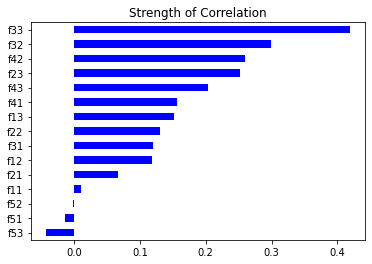

In [8]:
corr = df.corrwith(outcome)
corr.sort_values().plot.barh(color = 'blue',title = 'Strength of Correlation')

          f11       f12       f13       f21       f22       f23       f31  \
f11  1.000000  0.144669  0.222648 -0.013423 -0.012388 -0.006089  0.060657   
f12  0.144669  1.000000  0.479840 -0.004629  0.021946  0.018518 -0.004182   
f13  0.222648  0.479840  1.000000  0.008715  0.012480  0.032012  0.002789   
f21 -0.013423 -0.004629  0.008715  1.000000  0.057633  0.157461 -0.003220   
f22 -0.012388  0.021946  0.012480  0.057633  1.000000  0.358048  0.002514   
f23 -0.006089  0.018518  0.032012  0.157461  0.358048  1.000000 -0.008532   
f31  0.060657 -0.004182  0.002789 -0.003220  0.002514 -0.008532  1.000000   
f32  0.017245  0.028576  0.020068  0.001106  0.002526 -0.005859  0.153568   
f33 -0.018411 -0.000829  0.004984  0.004907 -0.016451 -0.005970  0.196196   
f41  0.074234  0.208603  0.287385  0.055468  0.120828  0.251741 -0.002046   
f42 -0.016170  0.011354  0.022560  0.049671  0.111974  0.244923  0.071682   
f43  0.116776  0.166995  0.274451  0.013200  0.010678  0.008900  0.053082   

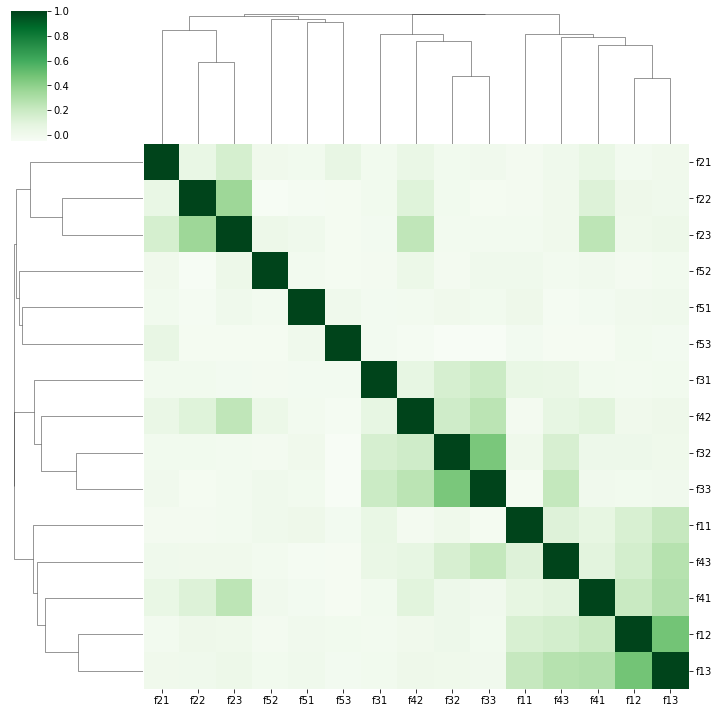

In [25]:
corr_matrix = df.corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(10,10),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [10]:
corr

f11    0.010708
f12    0.118399
f13    0.151713
f21    0.066591
f22    0.130051
f23    0.251469
f31    0.119517
f32    0.299740
f33    0.419468
f41    0.156241
f42    0.259093
f43    0.203022
f51   -0.014487
f52   -0.002196
f53   -0.043207
dtype: float64

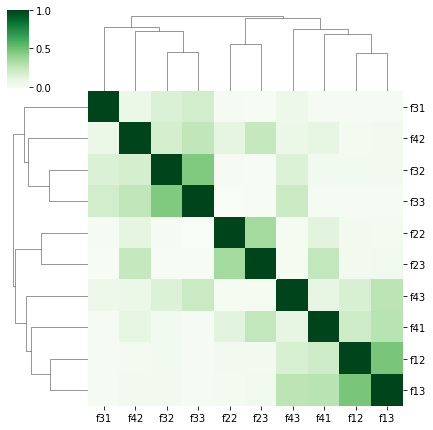

Correlation Strength:
f33    0.419468
f32    0.299740
f42    0.259093
f23    0.251469
f43    0.203022
f41    0.156241
f13    0.151713
f22    0.130051
f31    0.119517
f12    0.118399
dtype: float64


In [11]:
correlated_features = corr[corr>0.1].index.tolist()
corr_matrix = df[correlated_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), \
                            method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns
print("Correlation Strength:")
print(corr[corr>0.1].sort_values(ascending=False))

/Users/taejunpark/.pyenv/versions/3.7.7/envs/dp/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


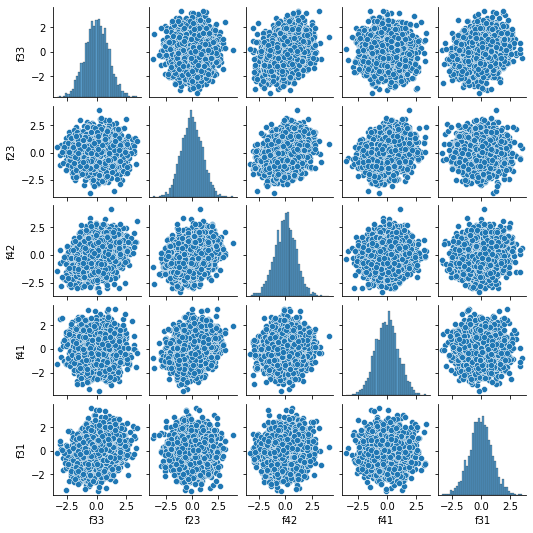

In [12]:
selected_features = ['f33','f23','f42','f41','f31']
import seaborn as sns
sns.pairplot(df[selected_features],size=1.5)

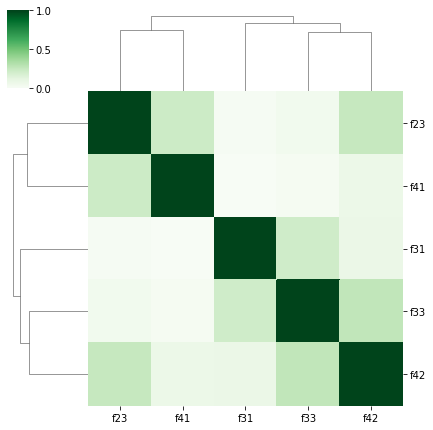

In [28]:
corr_matrix = df[selected_features].corr()
correlations_array = np.asarray(corr_matrix)

linkage = hierarchy.linkage(distance.pdist(correlations_array), method='average')

g = sns.clustermap(corr_matrix,row_linkage=linkage,col_linkage=linkage,\
                   row_cluster=True,col_cluster=True,figsize=(6,6),cmap='Greens')
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

label_order = corr_matrix.iloc[:,g.dendrogram_row.reordered_ind].columns

In [45]:
tmp = df[selected_features].join(outcome_scaled).reset_index().set_index('date')
tmp_mean = tmp.dropna().resample('Q').mean()
print(tmp_mean.iloc[:,:].unstack()) #plot(title='Correlation of Featrues to Outcome\n (by quarter)')\
#.iloc[:, :-1].plot(title='Correlation of Features to Outcome\n (by quarter)')
# shows time stability

         date      
f33      2012-03-31   -0.035197
         2012-06-30   -0.054081
         2012-09-30   -0.138160
         2012-12-31    0.234650
         2013-03-31   -0.126713
                         ...   
outcome  2017-03-31    0.097138
         2017-06-30   -0.062857
         2017-09-30   -0.041660
         2017-12-31    0.043780
         2018-03-31   -0.013420
Length: 150, dtype: float64
